In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
from ndlib.utils import multi_runs
from aesara import tensor as at
from bokeh.io import output_notebook, show
# from ndlib.viz.bokeh.DiffusionTrend import DiffusionTrend
from ndlib.viz.mpl.TrendComparison import DiffusionTrendComparison
import pysindy as ps
from pydmd import DMD
from ParameterConfig import DATA_DIR, FIGURE_DIR, ROOT_DIR, CPP_DATA_DIR
import glob
import pandas as pd



def load_SIR_trajectories(filename):
    trajs = glob.glob(CPP_DATA_DIR + "*.csv")
    dfs = [pd.read_csv(traj) for traj in trajs]
    N_traj = len(dfs)
    X = [df[['S', 'I', 'R']].to_numpy() for df in dfs]
    U = [df['p_I'].to_numpy() for df in dfs]

    return X, U

def plot_separate(X, reg_model):
    x_grouped = [X[:,i,:] for i in range(3)]
    X_list = [x.T for x in X]
    fig, ax = plt.subplots(3,2)
    t = np.linspace(0,1,x_grouped[0].shape[1])
    sim = reg_model.simulate(x0=X_list[0][0,:], t=np.linspace(0,1, t.shape[0]))

    for ci in np.arange(95, 10, -5):
        for (i, x) in enumerate(x_grouped):
            low = np.percentile(x, 50 - ci / 2, axis=0)
            high = np.percentile(x, 50 + ci / 2, axis=0)
            ax[i,0].fill_between(t, low, high, color='gray', alpha= np.exp(-.01*ci))

    ax[0,0].set_title("Susceptible")
    ax[1,0].set_title("Infected")
    ax[2,0].set_title("Recovered")
    _ = [x.grid() for x in ax[:,0]]
    _ = [x.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) for x in ax[:,0]]
    _ = [x.tick_params(axis='y', which='both', bottom=False, top=False, labelbottom=False) for x in ax[:,0]]
    
    for i in range(N_sim):
        x0 = X_list[i][0,:]
        sim = reg_model.simulate(x0=x0, t=np.linspace(0,1, t.shape[0]))
        ax[0,1].plot(t,sim[:,0], color='k')
        ax[1,1].plot(t, sim[:,1], color='k')
        ax[2,1].plot(t, sim[:,2], color='k')

    ax[0,1].set_title("Susceptible")
    ax[1,1].set_title("Infected")
    ax[2,1].set_title("Recovered")
    _ = [x.grid() for x in ax[:,1]]
    _ = [x.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) for x in ax[:,1]]
    _ = [x.tick_params(axis='y', which='both', bottom=False, top=False, labelbottom=False) for x in ax[:,1]]
    
def plot_merged(X, U, reg_model):
    x_grouped = [np.concatenate([x[:,i][:, np.newaxis] for x in X], axis=1) for i in range(3)]
    fig, ax = plt.subplots(4)
    t = np.linspace(0,1,X[0].shape[0])
    sim = reg_model.simulate(x0=X[0][0,:], u=U, t=np.linspace(0,1, t.shape[0]))
    print(x_grouped[0].shape)
    for ci in np.arange(95, 10, -5):
        for (i, x) in enumerate(x_grouped):
            low = np.percentile(x, 50 - ci / 2, axis=1)
            high = np.percentile(x, 50 + ci / 2, axis=1)
            ax[i].fill_between(t, low, high, color='gray', alpha= np.exp(-.01*ci))

    ax[0].set_title("Susceptible")
    ax[1].set_title("Infected")
    ax[2].set_title("Recovered")
    _ = [x.grid() for x in ax[:]]
    _ = [x.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) for x in ax]
    _ = [x.tick_params(axis='y', which='both', bottom=False, top=False, labelbottom=False) for x in ax]
    
    sim = reg_model.simulate(x0=X[0][0,:], u= U, t=np.linspace(0,1, U.shape[0]))
    print(sim.shape)
    ax[0].plot(t[:-1],sim[:,0], color='k')
    ax[1].plot(t[:-1], sim[:,1], color='k')
    ax[2].plot(t[:-1], sim[:,2], color='k')
    ax[3].plot(t, U, color='k')
    fig.subplots_adjust(hspace=.3)

    return fig, ax




In [3]:
X_data, U_data = load_SIR_trajectories('SIR_trajectories_20_0.1.csv')
X_mat = np.stack(X_data, axis=2)


In [122]:
U_mean = np.mean(U_data, axis=0)
X0_mean = np.mean(X_mat[0,:,:], axis=1)
X_mean = np.mean(X_mat, axis=2)
Nt = X_data[0].shape[0]
N_sim = len(X_data)
# In[8]:


t = [*list(range(Nt))]*N_sim

# In[10]:


# from Quantile_STLSQ import Quantile_STLSQ
# from Quantile_FROLS import Quantile_FROLS
# reg_model = ps.SINDy(Quantile_STLSQ(tau=.95, threshold=1e-6, alpha=1e-6))
# reg_model = ps.SINDy(Quantile_FROLS(tau=.95, verbose=True, max_iter = 3))
lowPolyLib = ps.PolynomialLibrary(degree=2, interaction_only=True)
# reg_model = ps.SINDy(ps.STLSQ(threshold=5), feature_library=lowPolyLib)
reg_model = ps.SINDy(ps.FROLS(max_iter=4), feature_library=lowPolyLib)
reg_model.fit(X_data[0],u=U_data[0], t=np.linspace(0,1,Nt))

reg_model.print()



(x0)' = 12.421 x0 + -1.563 x0 x1 + 1.117 x0 x2 + -338.126 x0 u0
(x1)' = -12.167 x0 + -0.853 x1 + 1.522 x0 x1 + 374.873 x0 u0
(x2)' = 1.164 x1 + 5.241 x2 + 6.087 x0 x2 + -0.158 x1 x2


In [123]:
from pysindy_casadi_converter import construct_mx_equations
import casadi as cs
Nx = 3
Nu = 1
xk = cs.MX.sym('X', Nx)
uk = cs.MX.sym('U', Nu)
eqs = cs.vertcat(*construct_mx_equations(xk, uk, reg_model))
F = cs.Function('F', [xk, uk], [eqs])

In [124]:
def RK4(f, x0, u, h):
    k1 = h*f(x0, u)
    k2 = h*f(x0 + k1/2, u)
    k3 = h*f(x0 + k2/2, u)
    k4 = h*f(x0 + k3, u)
    return x0 + (k1 + 2*k2 + 2*k3 + k4)/6

def N_RK4(f, x0, u, h, N):
    xk = x0
    for i in range(N):
        xk = RK4(f, xk, u, h/N)
    return xk

In [132]:
dt = .01
# F_integrator = cs.Function('F_integrator', [xk, uk], [xk_1])
xk_1 = N_RK4(F, xk, uk, dt, 8)
F_integrator = cs.Function('F_integrator', [xk, uk], [xk_1])

In [140]:
X = cs.MX.sym('X', Nx, Nt)
U = cs.MX.sym('U', Nu, Nt)
U0 = U_mean

g = []
N_pop = 60
I0 = .1*N_pop
u_max = .1
u_min = 0.01
obj = 0
Xk = X0_mean
I_max = N_pop-10
# for i in range(Nt):
#     Xk = F_integrator(Xk, U[i])
#     obj += (u_max-U[i])**2
#     g.append(I_max - Xk[1])
gI = []
gx = []
for i in range(Nt):
    if (i == 0):
        g.append(X[:,i] - X0_mean)
    gx.append(X[:,i] - F_integrator(X[:,i-1], U[i]))
    obj += (u_max - U[i])**2
    gI.append(I_max-Xk[1])
gx = cs.vertcat(*gx)
gI = cs.vertcat(*gI)

g = gx

In [144]:
X0 = cs.DM(3, Nt)
X0[:,0] = X0_mean
U0 = cs.DM.ones(Nt)*u_max
for i in range(Nt-1):
    X0[:,i+1] = F_integrator(X0[:,i], U0[i])

In [145]:

W = cs.vertcat(X.reshape((-1,1)), U.T)
W0 = cs.vertcat(X0.reshape((-1,1)), U0)
# prob = {'f': obj, 'x': W, 'g': g}
# solver = cs.nlpsol('solver', 'ipopt', prob)
lbw = [0]*Nx*Nt, [u_min]*Nt
lbw = cs.vertcat(*lbw)
ubx = cs.DM.ones(Nx*Nt)*N_pop
for i in range(Nt):
    ubx[1+3*i] = I_max
ubw = cs.vertcat(ubx, cs.DM.ones(Nt)*u_max)
Ng = g.shape[0]
lbg = cs.DM.zeros(Ng)
ubg = cs.DM.zeros(gx.shape[0])
# sol = solver(x0=cs.vertcat(X0[:], U_mean), lbx = lbw, ubx = ubw, lbg = lbg, ubg=ubg)
prob = {'f': obj, 'x': W, 'g': g}
solver = cs.nlpsol('solver', 'ipopt', prob)
sol = solver(x0=W0, lbx = lbw, ubx = ubw, lbg = lbg, ubg=ubg)


This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1500
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1000

Total number of variables............................:      400
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      400
                     variables with only upper bounds:        0
Total number of equality constraints.................:      300
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  8.0998236e-05 5.39e+01 1.64e-03  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [102]:
U0

DM([0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3])

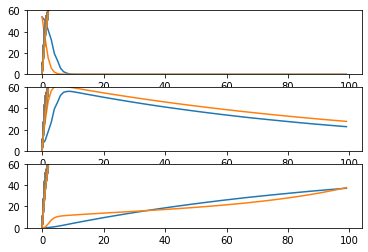

In [146]:
fig, ax = plt.subplots(3)
X_sol = sol['x'][:-Nt].reshape((Nx, Nt))
for i in range(Nx):
    ax[i].plot(X_mean[:,i])
    ax[i].plot(X0.full()[i,:].T)
    ax[i].plot(X_sol.full()[i,:])
    ax[i].set_ylim([0, N_pop])

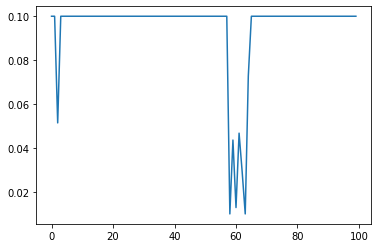

In [137]:
plt.plot(sol['x'][-Nt:].full())

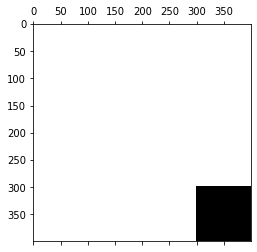

In [ ]:
lbd = cs.MX.sym('lbd', g.shape[0])
sparsity = cs.jacobian(cs.jacobian(obj + lbd.T @ g, W), W).sparsity()
plt.spy(sparsity)

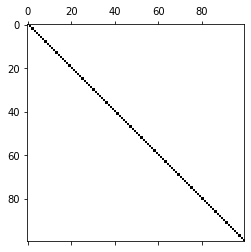

In [ ]:
sparsity = cs.jacobian(cs.jacobian(obj, U), U).sparsity()
plt.spy(sparsity)

In [ ]:
print(np.linalg.matrix_rank(sparsity), sparsity.shape[0])

100 100


In [ ]:
fig, ax = plot_merged(X, U_mean, reg_model)

fig.savefig(FIGURE_DIR + 'SIR_merged.png', bbox_inches='tight')
fig.show()

Exception: CasADi matrices are not iterable by design.
                      Did you mean to iterate over m.nz, with m IM/DM/SX?
                      Did you mean to iterate over horzsplit(m,1)/vertsplit(m,1) with m IM/DM/SX/MX?
                      